In [1]:
import copy
import os, sys
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.interpolate import interp1d

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

import sys
import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST
from COSMOS import COSMOS

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst
from PlotterCOSMOS import PlotterCOSMOS

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

In [2]:
def mass_completeness_limit_hst(z):
    
    x_values = [0.5, 0.65, 1.0, 1.5, 2.1, 3.0]
    y_values = [8.72, 8.72, 9.07, 9.63, 9.79, 10.15]
    
    f = interp1d(x_values, y_values)
    return f(z)


def mass_completeness_limit_cosmos(z):
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]

    f = interp1d(x_values, y_values)
    return f(z)


# def mass_completeness_limit_bgs(z):
#     f, b, c = [-1.34199453, 13.90578909,  8.53522654]
#     return 4*np.pi*f*z**2 + b*z + c


def mass_completeness_limit_bgs(z):
    x_values = np.array([0.00247985, 0.00483082, 0.00656047, 0.0090045 , 0.01228954,
       0.01468146, 0.01739703, 0.01982065, 0.02223816, 0.02478942,
       0.02718216, 0.0297723 , 0.03214576, 0.03475644, 0.03725439,
       0.03969578, 0.04231814, 0.04471862, 0.04726608, 0.04971804,
       0.05217666, 0.05485575, 0.05714361, 0.05983116, 0.0622433 ,
       0.06477037, 0.06729212, 0.0696601 , 0.07221736, 0.07470074,
       0.07726848, 0.07970581, 0.08235858, 0.08472435, 0.08723007,
       0.08963203, 0.09228077, 0.09477242, 0.09729331, 0.099802  ,
       0.10227854, 0.10469317, 0.10715788, 0.10972896, 0.11231016,
       0.11474048, 0.11718   , 0.11978621, 0.12227634, 0.12479607,
       0.12729936, 0.12974797, 0.13225808, 0.13471149, 0.13727515,
       0.13970204, 0.14227686, 0.14457675, 0.14727102, 0.14978783,
       0.15221812, 0.15465339, 0.15732456, 0.15978838, 0.1621385 ,
       0.16474496, 0.16723761, 0.16974835, 0.17225687, 0.17476975,
       0.17729319, 0.17983345, 0.18223385, 0.18479195, 0.18722791,
       0.1897866 , 0.19230325, 0.19474093, 0.1972761 , 0.19978505,
       0.20218162, 0.20478321, 0.20722114, 0.20978526, 0.2123442 ,
       0.21464457, 0.21721705, 0.21974108, 0.22214348, 0.22478031,
       0.22732483, 0.22962546, 0.23230192, 0.23478154, 0.23726658,
       0.23973219, 0.24223737, 0.24477807, 0.24733377, 0.24963889,
       0.25230877, 0.2547754 , 0.25726801, 0.25967258, 0.26232256,
       0.26477256, 0.26728391, 0.26966953, 0.27217287, 0.27460324,
       0.27722196, 0.27959586, 0.28229134, 0.2848037 , 0.28725984,
       0.28985701, 0.2923195 , 0.29462396, 0.29705607])
    
    y_values = np.array([ 6.19233606,  6.83089859,  7.19541283,  7.49541767,  7.73446394,
        7.97573148,  8.1206893 ,  8.28289916,  8.38297483,  8.4857448 ,
        8.5662122 ,  8.65428108,  8.68919015,  8.79760012,  8.85287516,
        8.91898337,  9.00431108,  9.04462424,  9.09902614,  9.12211824,
        9.19599217,  9.27656627,  9.28617265,  9.35747078,  9.38232742,
        9.42622197,  9.48121354,  9.49533128,  9.55465837,  9.58076478,
        9.61429673,  9.64659735,  9.68782778,  9.7159304 ,  9.75738293,
        9.79091068,  9.81607921,  9.82226304,  9.85758522,  9.87375352,
        9.8906075 ,  9.90740924,  9.9281017 ,  9.97121565,  9.98271625,
        9.99167673, 10.01813817, 10.04717844, 10.07974563, 10.09122367,
       10.09460286, 10.1539076 , 10.14871284, 10.16391119, 10.18545648,
       10.20465581, 10.23759639, 10.24537951, 10.25409408, 10.27692096,
       10.30349627, 10.3382326 , 10.33327252, 10.35523964, 10.35273232,
       10.37603491, 10.41671427, 10.41610546, 10.43212978, 10.47420657,
       10.46000597, 10.47431897, 10.48711649, 10.51094253, 10.51319548,
       10.52246781, 10.55200452, 10.56919663, 10.56833965, 10.58467215,
       10.61157816, 10.60453819, 10.63106187, 10.63100251, 10.63726941,
       10.65600309, 10.66358378, 10.67474176, 10.69383125, 10.69470662,
       10.71030144, 10.72679253, 10.73585073, 10.75277773, 10.76502898,
       10.78441052, 10.78582517, 10.8062511 , 10.80029193, 10.80723995,
       10.83403985, 10.87394328, 10.86794826, 10.87265313, 10.89667329,
       10.88012479, 10.87382357, 10.92230226, 10.91554066, 10.91910413,
       10.93963065, 10.95808569, 10.95081633, 10.97014478, 10.99860375,
       11.01836781, 11.03326512, 11.03070553, 11.03879802])
    
    f = interp1d(x_values, y_values, fill_value='extrapolate')
    return f(z)


def zmax_lim_bgs(mstar):
    x_values = np.array([0.00247985, 0.00483082, 0.00656047, 0.0090045 , 0.01228954,
       0.01468146, 0.01739703, 0.01982065, 0.02223816, 0.02478942,
       0.02718216, 0.0297723 , 0.03214576, 0.03475644, 0.03725439,
       0.03969578, 0.04231814, 0.04471862, 0.04726608, 0.04971804,
       0.05217666, 0.05485575, 0.05714361, 0.05983116, 0.0622433 ,
       0.06477037, 0.06729212, 0.0696601 , 0.07221736, 0.07470074,
       0.07726848, 0.07970581, 0.08235858, 0.08472435, 0.08723007,
       0.08963203, 0.09228077, 0.09477242, 0.09729331, 0.099802  ,
       0.10227854, 0.10469317, 0.10715788, 0.10972896, 0.11231016,
       0.11474048, 0.11718   , 0.11978621, 0.12227634, 0.12479607,
       0.12729936, 0.12974797, 0.13225808, 0.13471149, 0.13727515,
       0.13970204, 0.14227686, 0.14457675, 0.14727102, 0.14978783,
       0.15221812, 0.15465339, 0.15732456, 0.15978838, 0.1621385 ,
       0.16474496, 0.16723761, 0.16974835, 0.17225687, 0.17476975,
       0.17729319, 0.17983345, 0.18223385, 0.18479195, 0.18722791,
       0.1897866 , 0.19230325, 0.19474093, 0.1972761 , 0.19978505,
       0.20218162, 0.20478321, 0.20722114, 0.20978526, 0.2123442 ,
       0.21464457, 0.21721705, 0.21974108, 0.22214348, 0.22478031,
       0.22732483, 0.22962546, 0.23230192, 0.23478154, 0.23726658,
       0.23973219, 0.24223737, 0.24477807, 0.24733377, 0.24963889,
       0.25230877, 0.2547754 , 0.25726801, 0.25967258, 0.26232256,
       0.26477256, 0.26728391, 0.26966953, 0.27217287, 0.27460324,
       0.27722196, 0.27959586, 0.28229134, 0.2848037 , 0.28725984,
       0.28985701, 0.2923195 , 0.29462396, 0.29705607])
    
    y_values = np.array([ 6.19233606,  6.83089859,  7.19541283,  7.49541767,  7.73446394,
        7.97573148,  8.1206893 ,  8.28289916,  8.38297483,  8.4857448 ,
        8.5662122 ,  8.65428108,  8.68919015,  8.79760012,  8.85287516,
        8.91898337,  9.00431108,  9.04462424,  9.09902614,  9.12211824,
        9.19599217,  9.27656627,  9.28617265,  9.35747078,  9.38232742,
        9.42622197,  9.48121354,  9.49533128,  9.55465837,  9.58076478,
        9.61429673,  9.64659735,  9.68782778,  9.7159304 ,  9.75738293,
        9.79091068,  9.81607921,  9.82226304,  9.85758522,  9.87375352,
        9.8906075 ,  9.90740924,  9.9281017 ,  9.97121565,  9.98271625,
        9.99167673, 10.01813817, 10.04717844, 10.07974563, 10.09122367,
       10.09460286, 10.1539076 , 10.14871284, 10.16391119, 10.18545648,
       10.20465581, 10.23759639, 10.24537951, 10.25409408, 10.27692096,
       10.30349627, 10.3382326 , 10.33327252, 10.35523964, 10.35273232,
       10.37603491, 10.41671427, 10.41610546, 10.43212978, 10.47420657,
       10.46000597, 10.47431897, 10.48711649, 10.51094253, 10.51319548,
       10.52246781, 10.55200452, 10.56919663, 10.56833965, 10.58467215,
       10.61157816, 10.60453819, 10.63106187, 10.63100251, 10.63726941,
       10.65600309, 10.66358378, 10.67474176, 10.69383125, 10.69470662,
       10.71030144, 10.72679253, 10.73585073, 10.75277773, 10.76502898,
       10.78441052, 10.78582517, 10.8062511 , 10.80029193, 10.80723995,
       10.83403985, 10.87394328, 10.86794826, 10.87265313, 10.89667329,
       10.88012479, 10.87382357, 10.92230226, 10.91554066, 10.91910413,
       10.93963065, 10.95808569, 10.95081633, 10.97014478, 10.99860375,
       11.01836781, 11.03326512, 11.03070553, 11.03879802])

    f = interp1d(y_values, x_values)
    if mstar > y_values[-1]:
        return x_values[-1]
    else:
        return f(mstar)


    
def zmax_lim_cosmos(mstar):
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]

    f = interp1d(y_values, x_values)
    if mstar > y_values[-1]:
        return x_values[-1]
    else:
        return f(mstar)


def zmax_lim_hst(mstar):
    y_values = [8.72, 8.72, 9.07, 9.63, 9.79, 10.15]
    x_values = [0.5, 0.65, 1.0, 1.5, 2.1, 3.0]

    f = interp1d(y_values, x_values)
    if mstar > y_values[-1]:
        return x_values[-1]
    else:
        return f(mstar)

In [3]:
def gathering_data_hst(data, zmin, zmax):

    hst = data
    mask_zlim = (hst['z_peak'].data > zmin) & (hst['z_peak'].data < zmax)
    
    z_tot = hst['z_peak'].data[mask_zlim]
    x_tot = hst['lmass'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit_hst(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = (x_tot > mass_completeness_limit_hst(z_tot))  & (x_tot < 12.)
        
    
    mask = (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    
    return z, x

def gathering_data_cosmos(data, zmin, zmax):
    cosmos = data
    
    mask_ultra = (cosmos['FLAG_HJMCC']==0) & (cosmos['FLAG_COSMOS']==1) & (cosmos['FLAG_PETER']==0)
    
    z_tot = cosmos['ZPDF'][mask_ultra].data
    x_tot = cosmos['MASS_MED'][mask_ultra].data
    
    mask_zlim = (z_tot > zmin) & (z_tot < zmax) & (x_tot > 0)

    z2 = z_tot[mask_zlim]
    x2 = x_tot[mask_zlim]
    
    mask_mlim = (x2 > mass_completeness_limit_cosmos(z2))

    return z2[mask_mlim].astype(np.float32), x2[mask_mlim].astype(np.float32)



def gathering_data_bgs(data, zmin, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit_bgs(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit_bgs(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec, vmax

In [4]:
def normalisation(z0, zmin, zmax, x, z, best_params):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = best_params
    # v_zmin = Planck13.comoving_volume(zmin).value # (Mpc/h)^3
    # v_zmax = Planck13.comoving_volume(zmax).value # (Mpc/h)^3

    vzmin_bgs = Planck13.comoving_volume(zmin).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
    vzmax_bgs = Planck13.comoving_volume(zmax).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))
    
    vzmin_cosmos = Planck13.comoving_volume(zmin).value * 1.38 / 41253 
    vzmax_cosmos = Planck13.comoving_volume(zmax).value * 1.38 / 41253
    
    vzmin_hst = Planck13.comoving_volume(zmin).value * 0.25 / 41253 
    vzmax_hst = Planck13.comoving_volume(zmax).value * 0.25 / 41253 
    
    m_max = 13
    m_min = 6.
    nbin = 56
    bin_size = (m_max - m_min) / nbin
    x_median_bgs, x_cosmos, x_hst = x
    z_bgs, z_cosmos, z_hst = z

    x_bgs_bin = x_median_bgs[(z_bgs > zmin) & (z_bgs < zmax)]
    x_cosmos_bin = x_cosmos[(z_cosmos > zmin) & (z_cosmos < zmax)]
    x_hst_bin = x_hst[(z_hst > zmin) & (z_hst < zmax)]

    z_bgs_bin = z_bgs[(z_bgs > zmin) & (z_bgs < zmax)]
    z_cosmos_bin = z_cosmos[(z_cosmos > zmin) & (z_cosmos < zmax)]
    z_hst_bin = z_hst[(z_hst > zmin) & (z_hst < zmax)]

    I_bgs = [integrate.quad(smf_double_schechter_sty, mass_completeness_limit_bgs(z_bgs_bin)[i], 13., 
                            args=(z0, a0, a1, a2, alpha1, alpha2, a7, a8, a9))[0] for i in range(z_bgs_bin.shape[0])]

    I_cosmos = [integrate.quad(smf_double_schechter_sty, mass_completeness_limit_cosmos(z_cosmos_bin)[i], 13., 
                            args=(z0, a0, a1, a2, alpha1, alpha2, a7, a8, a9))[0] for i in range(z_cosmos_bin.shape[0])]
    
    I_hst = [integrate.quad(smf_double_schechter_sty, mass_completeness_limit_hst(z_hst_bin)[i], 13., 
                            args=(z0, a0, a1, a2, alpha1, alpha2, a7, a8, a9))[0] for i in range(z_hst_bin.shape[0])]

    N_bgs = 1 / (vzmax_bgs - vzmin_bgs) * np.sum((1.) / np.array(I_bgs))
    N_cosmos = 1 / (vzmax_cosmos - vzmin_cosmos) * np.sum((1.) / np.array(I_cosmos))
    N_hst = 1 / (vzmax_hst - vzmin_hst) * np.sum((1.) / np.array(I_hst))
    
    return N_bgs + N_cosmos + N_hst


def smf_double_schechter_sty(x, z,  a0, a1, a2, alpha1, alpha2, a7, a8, a9):
    logM = a0*z**2 + a1*z + a2
#     alpha1 = -.28
#     alpha2 = -1.48
    log_phi2_phi1 = a7*z**2 + a8*z + a9
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha2+1)*(x - logM))
    term2 = 10 ** ((alpha1+1)*(x - logM) + log_phi2_phi1)
    return term0 * (term1 + term2)

In [5]:
def plot_zschechter_double(x, z0, norm, best_params, **plot_params):
    a0, a1, a2, alpha1, alpha2, a7, a8, a9 = best_params
    zschechter = smf_double_schechter_sty(x, z0,  a0, a1, a2, alpha1, alpha2, a7, a8, a9)
    plt.plot(x, norm * zschechter, **plot_params)

    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)
    plt.xlim(7, 13)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc})^{-3}{\rm dex}^{-1}$]', fontsize=15)


def minimum_mlim(z):
    functions = [mass_completeness_limit_bgs, mass_completeness_limit_cosmos, mass_completeness_limit_hst]
    min_result = np.inf

    for func in functions:
        try:
            result = func(z)
            min_result = min(min_result,result)
        except Exception as e:
            pass
    return min_result

## $1/V_{max}$ for all catalogs

In [6]:
data_dir = '../data'
data_file_bgs = 'BGS_ANY_full.provabgs.lite.hdf5'
data_file_cosmos = 'COSMOS2015_Laigle+_v1.1.lite.hdf5'
data_file_hst = '3dhst_master.phot.v4.1.cat.lite.hdf5'

path_to_data_bgs = os.path.join(data_dir,data_file_bgs)
path_to_data_cosmos = os.path.join(data_dir,data_file_cosmos)
path_to_data_hst = os.path.join(data_dir,data_file_hst)

bgs = aTable.Table.read(path_to_data_bgs)
cosmos = aTable.Table.read(path_to_data_cosmos)
hst = aTable.Table.read(path_to_data_hst)


is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]

In [7]:
zmin_bgs, zmax_bgs = 0., 0.3
zmin_cosmos, zmax_cosmos = 0.2, 0.8
zmin_hst, zmax_hst = 0.5, 3.


z_bgs, x_bgs, x_median_bgs, w_spec, vmax_bgs = gathering_data_bgs(bgs, zmin_bgs, zmax_bgs)
z_cosmos, x_cosmos = gathering_data_cosmos(cosmos, zmin_cosmos, zmax_cosmos)
z_hst, x_hst = gathering_data_hst(hst, zmin_hst, zmax_hst)

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_8366/666842971.py:80: RuntimeWarning: divide by zero encountered in divide
  w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)


## BGS

In [8]:
# zmins = np.array([0.01 + 0.04 * i for i in range(4)])
# zmaxs = np.array([0.05 + 0.04 * i for i in range(4)])


# weights = (w_spec / v_max)
# hist, bin_edges = np.histogram(x_median_bgs, bins=40, range=(6., 13.), weights=weights)

# for zmin, zmax in zip(zmins, zmaxs):
#     v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
#     v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3

In [9]:
# h, b = np.histogram(x_cosmos_bin , weights=1/(vmax*0.23), bins=30, range=(6,13))
# plt.step(bin_edges[:-1], hist, where='post', linewidth=0.8, color='black', linestyle='--')
# plt.yscale('log')
# h[h == np.inf] = 0

## BGS

In [10]:
v_zmin_bgs = Planck13.comoving_volume(z_bgs.min()).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))# (Mpc)^3
vmax_bgs = np.array([Planck13.comoving_volume(zmax_lim_bgs(m_i)).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  - v_zmin_bgs for m_i in x_median_bgs])

## COSMOS

In [11]:
v_zmin_cosmos = Planck13.comoving_volume(0.2).value * 1.38 / 41253# (Mpc)^3
vmax_cosmos = np.array([Planck13.comoving_volume(zmax_lim_cosmos(m_i)).value * 1.38 / 41253  - v_zmin_cosmos for m_i in x_cosmos])

## HST

In [12]:
v_zmin_hst = Planck13.comoving_volume(0.5).value * 0.25 / 41253# (Mpc)^3
vmax_hst = np.array([Planck13.comoving_volume(zmax_lim_hst(m_i)).value * 0.25 / 41253  - v_zmin_hst for m_i in x_hst])

## $1/V_{max}$ plots

In [13]:
vmax_tot = np.concatenate((vmax_bgs, vmax_cosmos, vmax_hst), axis=0)
z_tot = np.concatenate((z_bgs, z_cosmos, z_hst), axis=0)
x_tot = np.concatenate((x_median_bgs, x_cosmos, x_hst), axis=0)

In [14]:
emcee_file = Fileh5(folder='emcee_runs', info_file='all_catalogs_newMlim_train1.0')
emcee_run = EmceeRun(emcee_file)
emcee_run.set_best_params(discard=200)

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_8366/3062782828.py:49: RuntimeWarning: divide by zero encountered in divide
  h, b = np.histogram(X , weights=1/(Vmax*0.23), bins=30, range=(6,13))


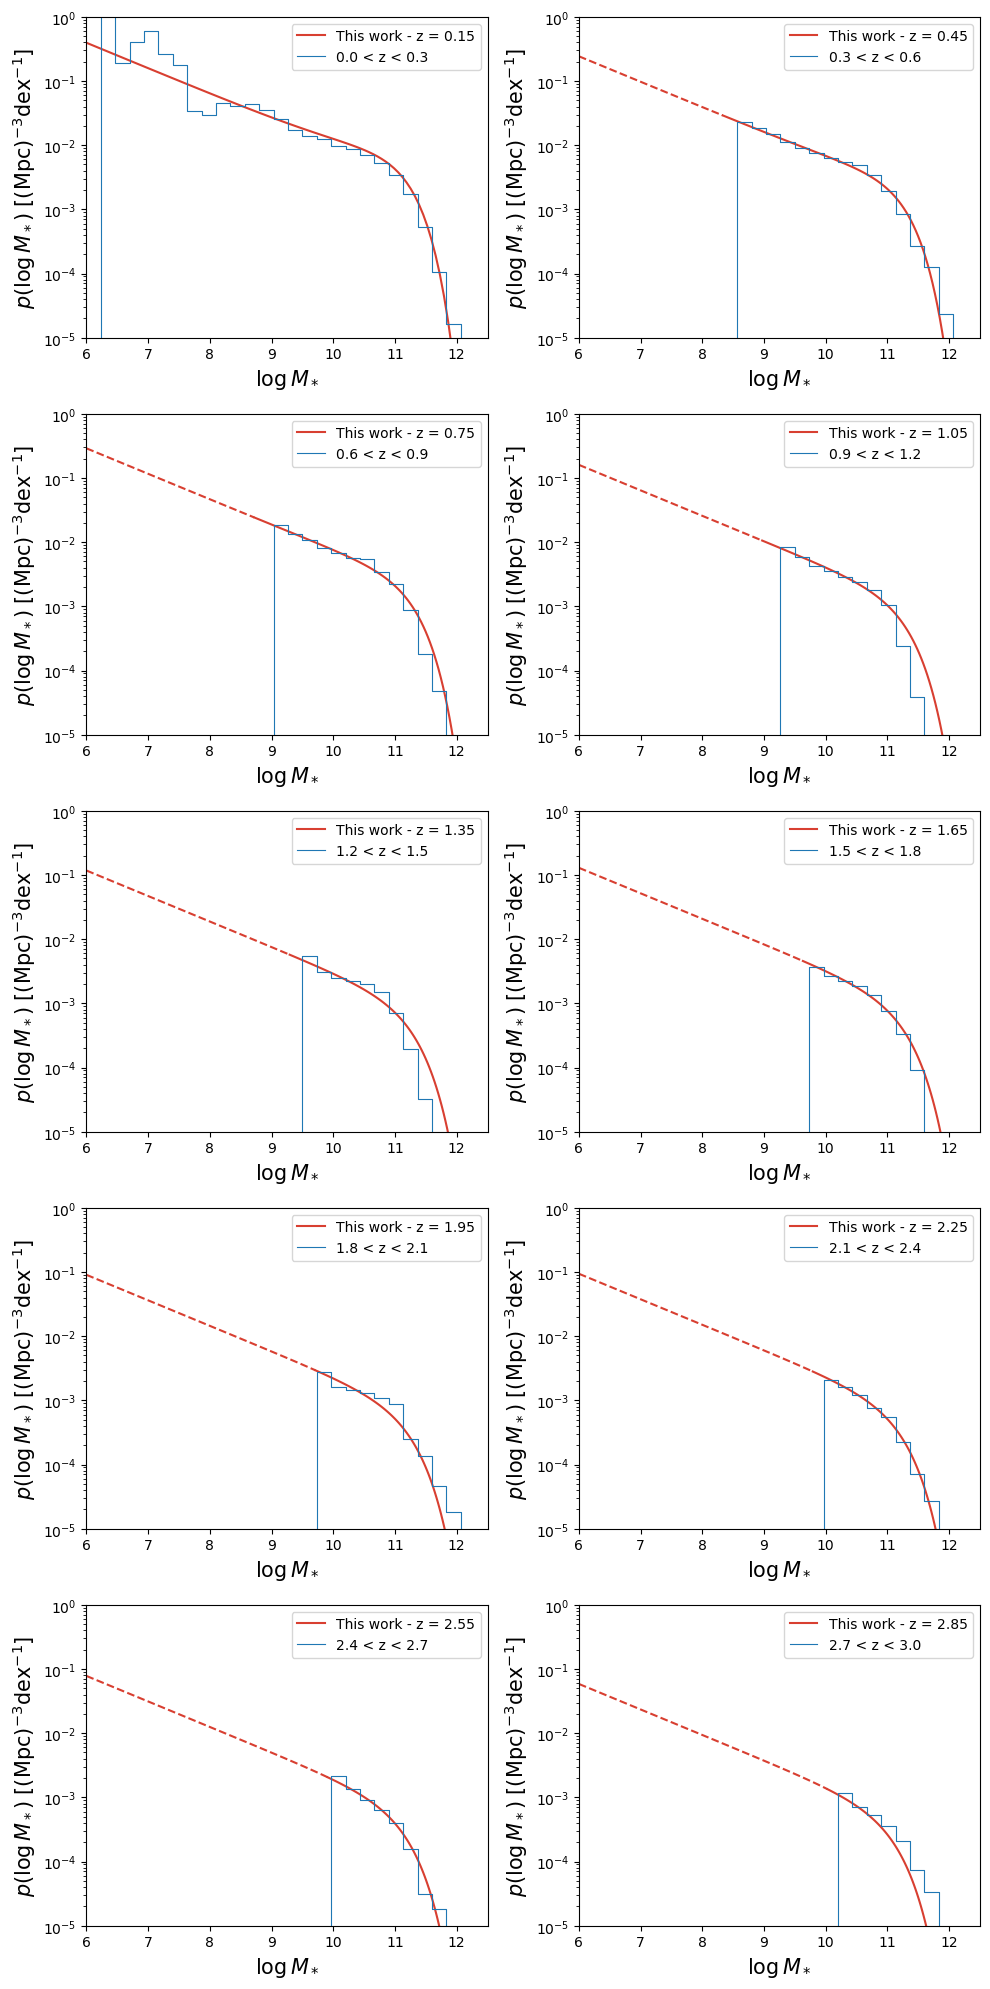

In [15]:
zmins = np.array([0. + 0.3 * i for i in range(10)])
zmaxs = np.array([0.3 + 0.3 * i for i in range(10)])
z0s = zmins + (zmaxs - zmins)/2


plt.figure(figsize=(10,20))
for p, zmin, zmax, z0_i in zip(range(0,10),zmins, zmaxs, z0s):
    plt.subplot(5, 2, p+1)

    # z, x = gathering_data_hst(hst,zmin,zmax)
    # x = xx[xx<12.]
    # z = zz[xx<12.]
    # vmax = np.array([Planck13.comoving_volume(zmax_lim_hst(m_i)).value * 0.25 / 41253  - v_zmin for m_i in x])
    mask = (z_tot > zmin) & (z_tot < zmax)
    x_bgs_bin = x_median_bgs[(z_bgs > zmin) & (z_bgs < zmax)]
    x_cosmos_bin = x_cosmos[(z_cosmos > zmin) & (z_cosmos < zmax)]
    x_hst_bin = x_hst[(z_hst > zmin) & (z_hst < zmax)]

    vmax_bgs_bin = vmax_bgs[(z_bgs > zmin) & (z_bgs < zmax)]
    vmax_cosmos_bin = vmax_cosmos[(z_cosmos > zmin) & (z_cosmos < zmax)]
    vmax_hst_bin = vmax_hst[(z_hst > zmin) & (z_hst < zmax)]

    vzmin_bgs = Planck13.comoving_volume(zmin).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
    vzmax_bgs = Planck13.comoving_volume(zmax).value * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))
    
    vzmin_cosmos = Planck13.comoving_volume(zmin).value * 1.38 / 41253 
    vzmax_cosmos = Planck13.comoving_volume(zmax).value * 1.38 / 41253
    
    vzmin_hst = Planck13.comoving_volume(zmin).value * 0.25 / 41253 
    vzmax_hst = Planck13.comoving_volume(zmax).value * 0.25 / 41253 

    vmax = vmax_tot[mask]
    x = x_tot[mask]
    
    Vmax_bgs = vmax_bgs_bin.clip(vzmin_bgs, vzmax_bgs) - vzmin_bgs
    Vmax_cosmos = vmax_cosmos_bin.clip(vzmin_cosmos, vzmax_cosmos) - vzmin_cosmos
    Vmax_hst = vmax_hst_bin.clip(vzmin_hst, vzmax_hst) - vzmin_hst

    X = np.concatenate((x_bgs_bin, x_cosmos_bin, x_hst_bin), axis=0)
    Vmax = np.concatenate((Vmax_bgs, Vmax_cosmos, Vmax_hst), axis=0)
    
    norm = normalisation(z0_i, zmin, zmax, [x_median_bgs, x_cosmos, x_hst], [z_bgs, z_cosmos, z_hst], emcee_run.get_best_params())

    mlim = minimum_mlim(zmin)

    plot_zschechter_double(np.linspace(6,mlim, 100), z0_i, norm, emcee_run.get_best_params(), color='#D83F31', linestyle='--')
    plot_zschechter_double(np.linspace(mlim,12.2, 100), z0_i, norm, emcee_run.get_best_params(),
                           label=f'This work - z = {round(z0_i,2)}', color='#D83F31')
    h, b = np.histogram(X , weights=1/(Vmax*0.23), bins=30, range=(6,13))
    h[h == np.inf] = 0

    plt.step(b[:-1], h, where='post', linewidth=0.8, label=f'{round(zmin,2)} < z < {round(zmax,2)}')
    plt.yscale('log')
    plt.ylim(1e-5, 10**(0))
    plt.xlim(6,12.5)
    plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../paper/BGS+COSMOS+3D-HST_fit.png')
    

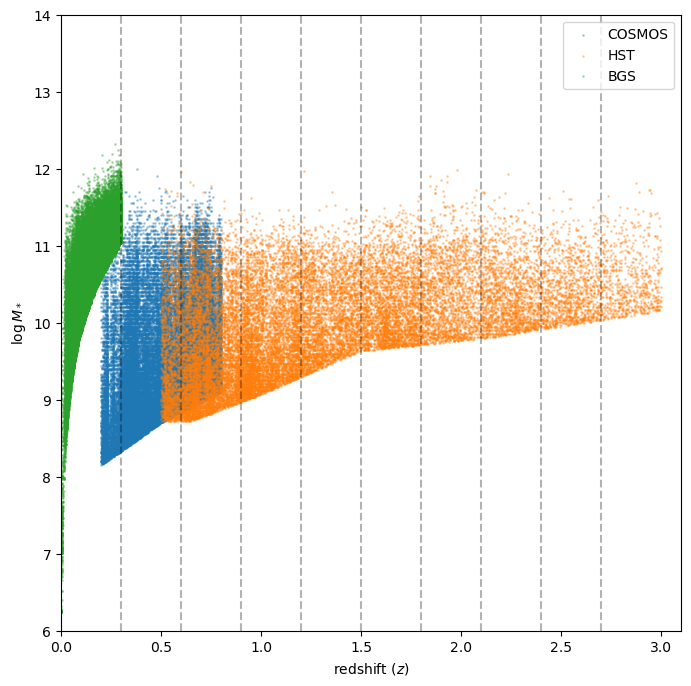

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(z_cosmos, x_cosmos, s=1, c='C0', label='COSMOS', alpha=0.3)
plt.scatter(z_hst, x_hst, s=1, c='C1', label='HST', alpha=0.3)

plt.scatter(z_bgs, x_median_bgs, s=1, c='C2', label='BGS', alpha=0.3)
# plt.scatter(z, x, s=1, c='C3', label='TOT')

for zmin, zmax in zip(zmins, zmaxs):
    plt.plot(np.repeat(zmin,100), np.linspace(6, 14, 100), linestyle='--', alpha=0.3, color='black')

plt.xlabel(r"redshift ($z$)")
plt.xlim(0., 3.1)
plt.ylabel(r"$\log M_*$")
plt.ylim(6., 14.)
plt.legend(loc='best')

In [17]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

In [18]:
age_cosmos = cosmo.age(z_cosmos).to_value()
age_hst = cosmo.age(z_hst).to_value()
age_bgs = cosmo.age(z_bgs).to_value()

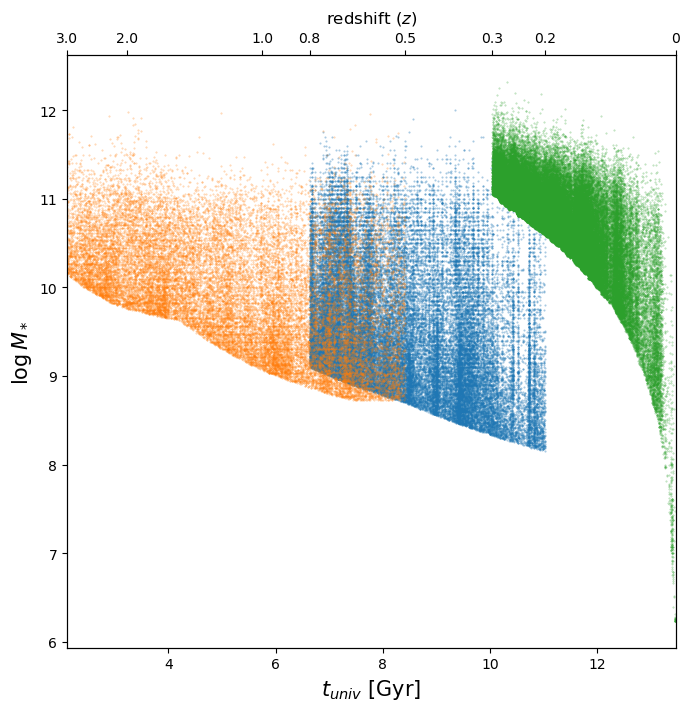

In [19]:
plt.figure(figsize=(7,7))
plt.plot(age_cosmos, x_cosmos, 'o', markersize=0.5, alpha=0.4)
plt.plot(age_hst, x_hst, 'o', markersize=0.4, alpha=0.4)
plt.plot(age_bgs, x_median_bgs, 'o', markersize=0.4, alpha=0.4)
plt.xlim(age_hst.min(), age_bgs.max())
plt.ylabel(r"$\log M_*$", fontsize=15)
plt.xlabel(r"$t_{univ}$ [Gyr]", fontsize=15)

plt.twiny()
plt.xlim(min(age_hst), max(age_bgs))
plt.xticks([age_bgs.max(), age_cosmos.max(), age_bgs.min(), age_hst.max(), age_cosmos.min(),
            cosmo.age(1).to_value(), cosmo.age(2).to_value(), age_hst.min()],
           ['0', '0.2', '0.3', '0.5', '0.8', '1.0', '2.0', '3.0'])

plt.tight_layout()
plt.title(r"redshift $(z)$")
plt.show()

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_8366/855092534.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Redshift')


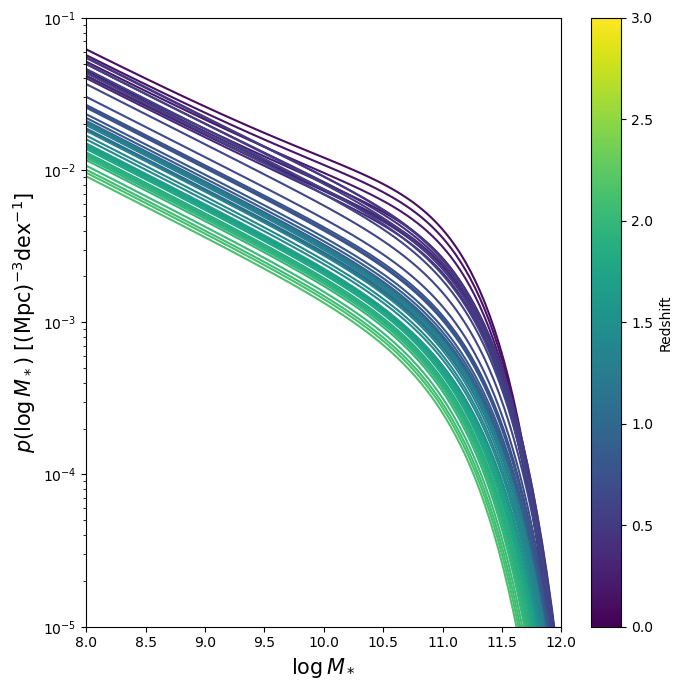

In [20]:
from matplotlib import cm
from matplotlib.colors import Normalize


plt.figure(figsize=(7,7))

_zmins = np.array([0. + 0.05 * i for i in range(55)])
_zmaxs = np.array([0.31 + 0.05 * i for i in range(55)])
_z0s = _zmins + (_zmaxs - _zmins)/2

for zmin, zmax, z0_i in zip(_zmins, _zmaxs, _z0s):
    # plt.subplot(3, 2, p+1)
    color = cm.viridis(z0_i / 4.)
    
    norm = normalisation(z0_i, zmin, zmax, [x_median_bgs, x_cosmos, x_hst], [z_bgs, z_cosmos, z_hst], emcee_run.get_best_params())
    plot_zschechter_double(np.linspace(8,12., 100), z0_i, norm, emcee_run.get_best_params(), label=f'{round(z0_i,2)}', color=color)
    plt.ylim(1e-5, 1e-1)
    plt.xlim(8,12.)
    # plt.legend(loc='best')

normal = Normalize(vmin=0., vmax=3.)  # You may need to adjust vmin and vmax based on your data
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=normal)
sm.set_array([])  # An empty array is needed for the scalar mappable
cbar = plt.colorbar(sm, label='Redshift')
plt.tight_layout()
plt.savefig('../paper/redshift_evo_schechter.png')

In [21]:
_zmins = np.array([0.01 + 0.05 * i for i in range(54)])
_zmaxs = np.array([0.31 + 0.05 * i for i in range(54)])
_z0s = _zmins + (_zmaxs - _zmins)/2

In [22]:
print(_z0s)

[0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66 0.71 0.76 0.81
 0.86 0.91 0.96 1.01 1.06 1.11 1.16 1.21 1.26 1.31 1.36 1.41 1.46 1.51
 1.56 1.61 1.66 1.71 1.76 1.81 1.86 1.91 1.96 2.01 2.06 2.11 2.16 2.21
 2.26 2.31 2.36 2.41 2.46 2.51 2.56 2.61 2.66 2.71 2.76 2.81]


In [23]:
print(_zmaxs)

[0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66 0.71 0.76 0.81 0.86 0.91 0.96
 1.01 1.06 1.11 1.16 1.21 1.26 1.31 1.36 1.41 1.46 1.51 1.56 1.61 1.66
 1.71 1.76 1.81 1.86 1.91 1.96 2.01 2.06 2.11 2.16 2.21 2.26 2.31 2.36
 2.41 2.46 2.51 2.56 2.61 2.66 2.71 2.76 2.81 2.86 2.91 2.96]
